In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()  

%matplotlib inline

pd.set_option('display.max_columns', 100)
os.chdir("C:\\Users\\sokol.ramaj\\Documents\\Kaggle\\Rossmann")

In [3]:
def read_files(train_fn, test_fn, store_fn):
    train = pd.read_csv(train_fn, parse_dates = ['Date'], infer_datetime_format = True)
    test = pd.read_csv(test_fn, parse_dates = ['Date'], infer_datetime_format = True)
    store = pd.read_csv(store_fn)
    
    return train, test, store

In [4]:
train, test, store = read_files('train.csv', 'test.csv', 'store.csv')

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
def myPinterval(x):
    if x=='Feb,May,Aug,Nov':  return([0,1,0,0,1,0,0,1,0,0,1,0])
    elif x=='Jan,Apr,Jul,Oct':  return([1,0,0,1,0,0,1,0,0,1,0,0])
    elif x== 'Mar,Jun,Sept,Dec': return([0,0,1,0,0,1,0,0,1,0,0,1])
    else: return(np.repeat(0,12).tolist())

train.StateHoliday = train.StateHoliday.map({'0':'0', 'a':'1', 'b': '2', 'c':'3'})
test.Open = test.Open.fillna(1)
distmean = store.CompetitionDistance.median()
store.CompetitionDistance = store.CompetitionDistance.fillna(distmean) 
proInt = store.PromoInterval.apply(myPinterval).tolist()
proInt = pd.DataFrame(proInt, columns = ['ProInt'+ str(i) for i in range(1,13)] , dtype=np.int8)
store = store.drop('PromoInterval',1).join(proInt)
store['CompetitionOpenSinceDay'] = 1
store['CompetitionOpenSinceDT'] = pd.to_datetime(dict(year=store.CompetitionOpenSinceYear, month=store.CompetitionOpenSinceMonth, day=store.CompetitionOpenSinceDay))
store = store.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','CompetitionOpenSinceDay'], axis='columns')
ifnulldt = pd.to_datetime('1970-01-01')
store.CompetitionOpenSinceDT = store.CompetitionOpenSinceDT.fillna(ifnulldt) 
store['Promo2Mon'] = 1
store['Promo2Day'] = 1
store['Promo2SinceDT'] = pd.to_datetime(dict(year=store.Promo2SinceYear, month=store.Promo2Mon, day=store.Promo2Day))
store = store.drop(['Promo2SinceYear','Promo2Mon','Promo2Day'], axis='columns') 
mask = store.Promo2SinceWeek.isnull() == False
store.loc[mask, 'Promo2SinceWeek'] = store[mask].Promo2SinceWeek.apply(lambda x: np.timedelta64(np.int(x), 'W'))
store['Promo2SinceDT'] = store['Promo2SinceDT'] + store['Promo2SinceWeek']
store = store.drop(['Promo2SinceWeek'], axis='columns')
store.Promo2SinceDT = store.Promo2SinceDT.fillna(ifnulldt)

In [9]:
def add_missing_dates(train, all_stores):
    train_m = pd.DataFrame()
    store_by_date = train.groupby('Date')['Store'].nunique().reset_index()
    for i in store_by_date.query('Store != 1115')['Date']:
        diff_stores = all_stores.difference(set(train[train['Date']==i].Store))
        s = list(diff_stores)
        missing = pd.DataFrame(data={
                                 'Date': [i]*len(s), 
                                 'Store': s, 
                                 'Customers': [0]*len(s),
                                 'Sales': [0]*len(s),
                                 'Open': [0]*len(s),
                                 'Promo': [0]*len(s),
                                 'SchoolHoliday': [0]*len(s),
                                 'StateHoliday': ['0']*len(s)
                                }) 
    
        train_m = train_m.append(missing)
        train_m['DayOfWeek'] = train_m.Date.dt.dayofweek+1
    
    store_by_date = train.groupby('Date')['Store'].nunique().reset_index()
    
    return train_m[['Store','DayOfWeek','Date','Sales','Customers','Open','Promo','StateHoliday','SchoolHoliday']]
   

In [10]:
missing_train = add_missing_dates(train, set(store.Store))
train = pd.concat([train, missing_train])

In [11]:
def split_date(df, date_col):
    n_date_year = df[date_col].dt.year
    n_date_month = df[date_col].dt.month
    n_date_weeknum = df[date_col].dt.weekofyear
    n_date_day = df[date_col].dt.day
    
    df = df.assign(date_year=n_date_year, date_month=n_date_month, date_weeknum=n_date_weeknum, date_day=n_date_day)
    return df
 
train = split_date(train, 'Date')
test = split_date(test, 'Date')

In [12]:
train_df = train.set_index('Store').join(store.set_index('Store'), how='inner').reset_index()
test_df = test.set_index('Store').join(store.set_index('Store'), how='inner').reset_index()

In [13]:
train_df.DayOfWeek = train_df.DayOfWeek.astype(str)
dummies = pd.get_dummies(train_df[['Assortment', 'StoreType', 'StateHoliday','DayOfWeek']])
train_df = train_df.join(dummies)
train_df = train_df.drop(['Assortment', 'StoreType', 'StateHoliday','DayOfWeek'], axis=1)

In [14]:
train_df = train_df.assign(days_since_comp = train_df['Date'] - train_df['CompetitionOpenSinceDT'])
train_df = train_df.assign(days_since_promo = train_df['Date'] - train_df['Promo2SinceDT'])
test_df = test_df.assign(days_since_comp = test_df['Date'] - test_df['CompetitionOpenSinceDT'])
test_df = test_df.assign(days_since_promo = test_df['Date'] - test_df['Promo2SinceDT'])

train_df.days_since_comp = (train_df.days_since_comp / np.timedelta64(1, 'D')).astype(int)
train_df.days_since_promo = (train_df.days_since_promo / np.timedelta64(1, 'D')).astype(int) 

test_df.days_since_comp = (test_df.days_since_comp / np.timedelta64(1, 'D')).astype(int)
test_df.days_since_promo = (test_df.days_since_promo / np.timedelta64(1, 'D')).astype(int) 

train_df.loc[train_df.CompetitionOpenSinceDT.dt.year <= 1970,'days_since_comp']
train_df.loc[train_df.days_since_comp < 0,'days_since_comp'] = 0
train_df.loc[train_df.Promo2SinceDT.dt.year <= 1970,'days_since_promo'] = 0
train_df.loc[train_df.days_since_promo < 0, 'days_since_promo'] = 0
test_df.loc[test_df.CompetitionOpenSinceDT.dt.year <= 1970,'days_since_comp']
test_df.loc[test_df.days_since_comp < 0,'days_since_comp'] = 0
test_df.loc[test_df.Promo2SinceDT.dt.year <= 1970,'days_since_promo'] = 0
test_df.loc[test_df.days_since_promo < 0, 'days_since_promo'] = 0


train_df.drop(['CompetitionOpenSinceDT','Promo2SinceDT'], axis=1, inplace=True)
test_df.drop(['CompetitionOpenSinceDT','Promo2SinceDT'], axis=1, inplace=True)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050330 entries, 0 to 1050329
Data columns (total 45 columns):
Store                  1050330 non-null int64
Date                   1050330 non-null datetime64[ns]
Sales                  1050330 non-null int64
Customers              1050330 non-null int64
Open                   1050330 non-null int64
Promo                  1050330 non-null int64
SchoolHoliday          1050330 non-null int64
date_day               1050330 non-null int64
date_month             1050330 non-null int64
date_weeknum           1050330 non-null int64
date_year              1050330 non-null int64
CompetitionDistance    1050330 non-null float64
Promo2                 1050330 non-null int64
ProInt1                1050330 non-null int8
ProInt2                1050330 non-null int8
ProInt3                1050330 non-null int8
ProInt4                1050330 non-null int8
ProInt5                1050330 non-null int8
ProInt6                1050330 non-null int8
ProInt7 

In [16]:
train_df = train_df.assign(is_promo = (train_df['date_month'] == 1) & (train_df['ProInt1'] == 1) |
                                     (train_df['date_month'] == 2) & (train_df['ProInt2'] == 1) | 
                                     (train_df['date_month'] == 3) & (train_df['ProInt3'] == 1) | 
                                     (train_df['date_month'] == 4) & (train_df['ProInt4'] == 1) | 
                                     (train_df['date_month'] == 5) & (train_df['ProInt5'] == 1) | 
                                     (train_df['date_month'] == 6) & (train_df['ProInt6'] == 1) | 
                                     (train_df['date_month'] == 7) & (train_df['ProInt7'] == 1) | 
                                     (train_df['date_month'] == 8) & (train_df['ProInt8'] == 1) | 
                                     (train_df['date_month'] == 9) & (train_df['ProInt9'] == 1) | 
                                     (train_df['date_month'] == 10) & (train_df['ProInt10'] == 1) | 
                                     (train_df['date_month'] == 11) & (train_df['ProInt11'] == 1) |
                                     (train_df['date_month'] == 12) & (train_df['ProInt12'] == 1))
train_df.is_promo = train_df.is_promo.astype(np.int8)
train_df.drop(['ProInt1' ,'ProInt2' ,'ProInt3',
               'ProInt4' ,'ProInt5' ,'ProInt6',
               'ProInt7' ,'ProInt8' ,'ProInt9',
               'ProInt10','ProInt11','ProInt12'], axis=1, inplace=True)
train_df.head()

Store       Date  Sales  Customers  Open  Promo  SchoolHoliday  date_day  \
0      1 2015-07-31   5263        555     1      1              1        31   
1      1 2015-07-30   5020        546     1      1              1        30   
2      1 2015-07-29   4782        523     1      1              1        29   
3      1 2015-07-28   5011        560     1      1              1        28   
4      1 2015-07-27   6102        612     1      1              1        27   

   date_month  date_weeknum  date_year  CompetitionDistance  Promo2  \
0           7            31       2015               1270.0       0   
1           7            31       2015               1270.0       0   
2           7            31       2015               1270.0       0   
3           7            31       2015               1270.0       0   
4           7            31       2015               1270.0       0   

   Assortment_a  Assortment_b  Assortment_c  StoreType_a  StoreType_b  \
0             1             0             0            0            0   
1             1             0             0            0            0   
2             1             0             0            0            0   
3             1             0             0            0            0   
4             1             0             0            0            0   

   StoreType_c  StoreType_d  StateHoliday_0  StateHoliday_1  StateHoliday_2  \
0            1            0               1               0               0   
1            1            0               1               0               0   
2            1            0               1               0               0   
3            1            0               1               0               0   
4            1            0               1               0               0   

   StateHoliday_3  DayOfWeek_1  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
0               0            0            0            0            0   
1               0            0            0            0            1   
2               0            0            0            1            0   
3               0            0            1            0            0   
4               0            1            0            0            0   

   DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  days_since_comp  days_since_promo  \
0            1            0            0             2524                 0   
1            0            0            0             2523                 0   
2            0            0            0             2522                 0   
3            0            0            0             2521                 0   
4            0            0            0             2520                 0   

   is_promo  
0         0  
1         0  
2         0  
3         0  
4         0

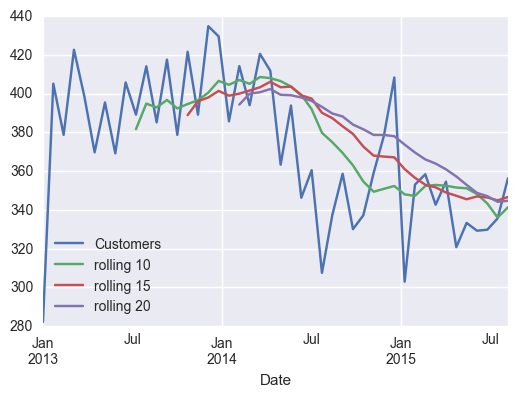

In [61]:
store111 = train_df.query('Store == 1111').set_index('Date')['Customers'].resample('3w').mean()
r10 = pd.Series(store111.rolling(10).mean(), name='rolling 10')
r15 = pd.Series(store111.rolling(15).mean(), name='rolling 15')
r20 = pd.Series(store111.rolling(20).mean(), name='rolling 20')
pd.concat([store111, r10, r15, r20], axis=1).plot()

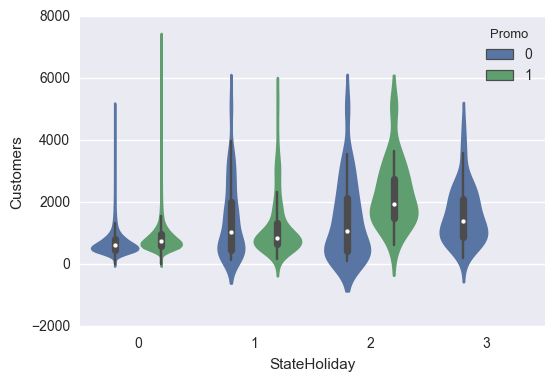

In [76]:
sns.violinplot('StateHoliday', 'Customers', data=train.query('Open == 1'), hue='Promo')

In [36]:
storex = train_df.query('Store == 1111') \
                 .pct_change() \
                 .pivot_table(columns='date_year', index='date_month',values=['Sales'], aggfunc=np.sum)
                 

fig, (ax1, ax2) = plt.subplots(2,1)
sns.heatmap(storex, annot=True, fmt='.2f', ax=ax1)
train_df.query('Store == 1111').set_index('Date')['Sales'].resample('m').sum().plot(ax=ax2)
fig.autofmt_xdate()
fig.set_size_inches(15,10)
fig.tight_layout()

TypeError: ufunc true_divide cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [58]:
train_df = train_df.set_index(['Store', 'Date']).sort_index()
test_df = test_df.set_index(['Store', 'Date']).sort_index()

In [86]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200)

X = train_df.loc[1096]

y1 = X.pop('Customers')
y2 = X.pop('Sales') 

clf.fit(X[500:-100], y1[500:-100])
y1_pred = clf.predict(X[-100:])
model_result = pd.DataFrame({'Y1_true':y1[-100:].values, 'y1_pred': y1_pred}, index=y1[-100:].index)
model_fimp = pd.DataFrame({'imp': clf.feature_importances_, 'feature': X.columns}).sort_values(by='imp')

print (clf.score(X[-100:], y1[-100:]))

0.922629007213


In [83]:
model_fimp.sort_values(by='imp', ascending=False)

feature       imp
0                  Open  0.848158
1                 Promo  0.034685
39         date_weeknum  0.034021
37             date_day  0.021043
28          DayOfWeek_1  0.014163
35      days_since_comp  0.011646
36     days_since_promo  0.010561
30          DayOfWeek_3  0.008364
38           date_month  0.007189
33          DayOfWeek_6  0.002754
2         SchoolHoliday  0.002339
32          DayOfWeek_5  0.001376
24       StateHoliday_0  0.001082
29          DayOfWeek_2  0.000980
31          DayOfWeek_4  0.000754
41             is_promo  0.000621
40            date_year  0.000263
23          StoreType_d  0.000000
25       StateHoliday_1  0.000000
11              ProInt7  0.000000
34          DayOfWeek_7  0.000000
20          StoreType_a  0.000000
3   CompetitionDistance  0.000000
4                Promo2  0.000000
22          StoreType_c  0.000000
21          StoreType_b  0.000000
19         Assortment_c  0.000000
18         Assortment_b  0.000000
17         Assortment_a  0.000000
16             ProInt12  0.000000
15             ProInt11  0.000000
14             ProInt10  0.000000
13              ProInt9  0.000000
26       StateHoliday_2  0.000000
12              ProInt8  0.000000
10              ProInt6  0.000000
9               ProInt5  0.000000
8               ProInt4  0.000000
7               ProInt3  0.000000
6               ProInt2  0.000000
5               ProInt1  0.000000
27       StateHoliday_3  0.000000

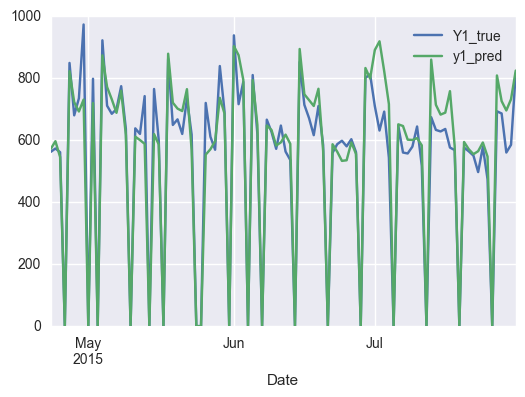

In [87]:
model_result.plot()

In [374]:
customer_score = []
customer_pred = []
customer_fimp = []
sales_score = []
sales_pred = []
sales_fimp = []

for i in np.random.randint(0,1114, 20): #store.index.values:
    print("Fitting store: ", i)
    X = train_df.loc[i]
    y1 = X.pop('Customers')
    y2 = X.pop('Sales')
    
    clf.fit(X[:-100], y1[:-100])
    y1_pred = clf.predict(X[-100:])
    y1_score = clf.score(X, y1)
    print("----Customer pred score: ", y1_score)
    
    customer_score.append(y1_score)
    customer_pred.append(y1_pred)
    customer_fimp.append(clf.feature_importances_)
    
    clf.fit(X[:-100], y2[:-100])
    y2_pred = clf.predict(X[-100:])
    y2_score = clf.score(X, y2)
    print("----Sales pred score: ", y2_score)
    
    sales_score.append(y2_score)
    sales_pred.append(y2_pred)
    sales_fimp.append(clf.feature_importances_)

Fitting store:  719
----Customer pred score:  0.984733312477
----Sales pred score:  0.982933119739
Fitting store:  470
----Customer pred score:  0.985727119571
----Sales pred score:  0.982908709296
Fitting store:  982
----Customer pred score:  0.988120518715
----Sales pred score:  0.986754823344
Fitting store:  231
----Customer pred score:  0.98926909622
----Sales pred score:  0.985611296716
Fitting store:  625
----Customer pred score:  0.98787397138
----Sales pred score:  0.987308210763
Fitting store:  967
----Customer pred score:  0.987292484645
----Sales pred score:  0.984099231209
Fitting store:  494
----Customer pred score:  0.940584203354
----Sales pred score:  0.956910485703
Fitting store:  945
----Customer pred score:  0.989615061611
----Sales pred score:  0.982620500746
Fitting store:  582
----Customer pred score:  0.98425467016
----Sales pred score:  0.9822390385
Fitting store:  175
----Customer pred score:  0.988291472973
----Sales pred score:  0.985439521076
Fitting store: 

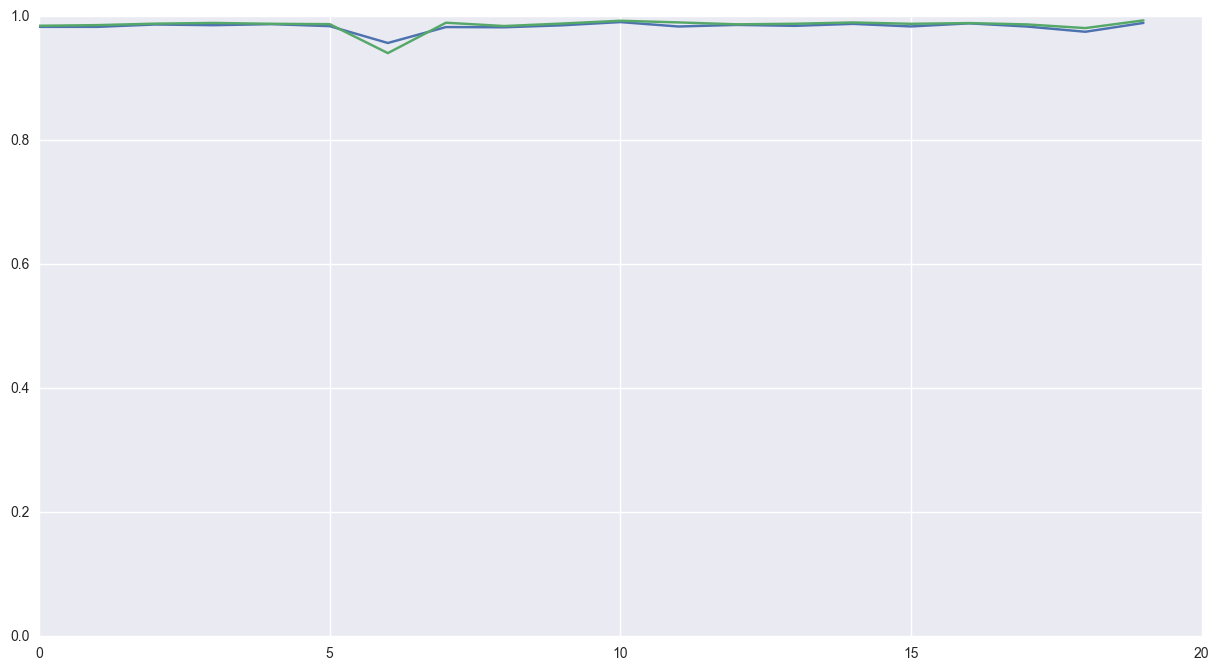

In [375]:
plt.figure(figsize=(15,8))
plt.plot(sales_score)
plt.plot(customer_score)
plt.ylim(0,1)
plt.show()

In [65]:
sp = train[['Store','Date','Sales']]
sales_pivot = sp.pivot(index='Store', columns='Date', values='Sales')
col_names = ['col_%d' % i for i in range(len(sales_pivot.columns))]
sales_pivot.columns = col_names


cp = train[['Store','Date','Customers']]
customers_pivot = cp.pivot(index='Store', columns='Date', values='Customers')
customers_pivot.columns = col_names
customers_pivot.head()

col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  col_9  \
Store                                                                         
1          0    668    578    619    635      0    785    654    626    615   
2          0    650    555    574    324      0    763    685    785    637   
3          0    805    721    690    525      0   1079    856    778    791   
4          0   1429   1248   1232   1514      0   1562   1325   1215   1285   
5          0    577    491    533    202      0    717    613    697    596   

       col_10  col_11  col_12  col_13  col_14  col_15  col_16  col_17  col_18  \
Store                                                                           
1         592     646       0     616     512     530     503     568     688   
2         539     337       0     530     513     591     403     434     303   
3         951     485       0     599     669     617     600     703     427   
4        1412    1461       0    1222    1074    1061    1090    1153    1427   
5         562     223       0     567     520     513     464     501     199   

       col_19  col_20  col_21  col_22  col_23  col_24  col_25  col_26  col_27  \
Store                                                                           
1           0     607     667     627     645     676     640       0     549   
2           0     662     656     690     582     522     303       0     488   
3           0     630     797     803     814     773     450       0     722   
4           0    1556    1323    1207    1203    1409    1326       0    1120   
5           0     618     626     667     512     564     187       0     451   

       col_28  col_29  col_30  col_31  col_32  col_33  col_34  col_35  col_36  \
Store                                                                           
1         522     560     571     658     701       0     762     678     693   
2         476     608     517     554     361       0     688     674     769   
3         711     647     648     806     603       0    1070     925     950   
4        1116    1065    1355    1363    1524       0    1750    1489    1411   
5         472     570     571     576     211       0     679     590     687   

       col_37  col_38  col_39  col_40  col_41  col_42  col_43  col_44  col_45  \
Store                                                                           
1         675     630     656       0     599     572     604     573     607   
2         638     491     354       0     582     504     678     574     494   
3         861     842     494       0     736     758     680     741     673   
4        1379    1380    1480       0    1386    1199    1193    1219    1147   
5         559     555     188       0     560     448     568     508     500   

       col_46  col_47  col_48  col_49   ...     col_892  col_893  col_894  \
Store                                   ...                                 
1         682       0     710     608   ...         422      502        0   
2         290       0     757     588   ...         480      319        0   
3         488       0    1008     755   ...         681      492        0   
4        1432       0    1660    1295   ...        1090     1370        0   
5         196       0     780     475   ...         500      234        0   

       col_895  col_896  col_897  col_898  col_899  col_900  col_901  col_902  \
Store                                                                           
1          586      503      476      498      487      494        0      489   
2          762      648      805      594      544      323        0      491   
3          955      911      821      743      797      424        0      638   
4         1473     1352     1254     1138     1281     1311        0     1230   
5          747      671      651      545      610      210        0      497   

       col_903  col_904  col_905  col_906  col_907  col_908  col_909  col

In [299]:
customers_pivot.head()

col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  col_9  \
Store                                                                         
1          0    668    578    619    635      0    785    654    626    615   
2          0    650    555    574    324      0    763    685    785    637   
3          0    805    721    690    525      0   1079    856    778    791   
4          0   1429   1248   1232   1514      0   1562   1325   1215   1285   
5          0    577    491    533    202      0    717    613    697    596   

       col_10  col_11  col_12  col_13  col_14  col_15  col_16  col_17  col_18  \
Store                                                                           
1         592     646       0     616     512     530     503     568     688   
2         539     337       0     530     513     591     403     434     303   
3         951     485       0     599     669     617     600     703     427   
4        1412    1461       0    1222    1074    1061    1090    1153    1427   
5         562     223       0     567     520     513     464     501     199   

       col_19  col_20  col_21  col_22  col_23  col_24  col_25  col_26  col_27  \
Store                                                                           
1           0     607     667     627     645     676     640       0     549   
2           0     662     656     690     582     522     303       0     488   
3           0     630     797     803     814     773     450       0     722   
4           0    1556    1323    1207    1203    1409    1326       0    1120   
5           0     618     626     667     512     564     187       0     451   

       col_28  col_29  col_30  col_31  col_32  col_33  col_34  col_35  col_36  \
Store                                                                           
1         522     560     571     658     701       0     762     678     693   
2         476     608     517     554     361       0     688     674     769   
3         711     647     648     806     603       0    1070     925     950   
4        1116    1065    1355    1363    1524       0    1750    1489    1411   
5         472     570     571     576     211       0     679     590     687   

       col_37  col_38  col_39  col_40  col_41  col_42  col_43  col_44  col_45  \
Store                                                                           
1         675     630     656       0     599     572     604     573     607   
2         638     491     354       0     582     504     678     574     494   
3         861     842     494       0     736     758     680     741     673   
4        1379    1380    1480       0    1386    1199    1193    1219    1147   
5         559     555     188       0     560     448     568     508     500   

       col_46  col_47  col_48  col_49   ...     col_892  col_893  col_894  \
Store                                   ...                                 
1         682       0     710     608   ...         422      502        0   
2         290       0     757     588   ...         480      319        0   
3         488       0    1008     755   ...         681      492        0   
4        1432       0    1660    1295   ...        1090     1370        0   
5         196       0     780     475   ...         500      234        0   

       col_895  col_896  col_897  col_898  col_899  col_900  col_901  col_902  \
Store                                                                           
1          586      503      476      498      487      494        0      489   
2          762      648      805      594      544      323        0      491   
3          955      911      821      743      797      424        0      638   
4         1473     1352     1254     1138     1281     1311        0     1230   
5          747      671      651      545      610      210        0      497   

       col_903  col_904  col_905  col_906  col_907  col_908  col_909  col

In [346]:
def plot_clusters(df, clu, xcol='Date', ycol='Customers'):
    fig, axes = plt.subplots(1, cl.n_clusters, sharex=True, sharey=True)
    
    for ax, l in zip(axes, np.unique(cl.labels_)):
        tdf = df.where(df['cluster'] == l).dropna()
        
        for i in tdf.index.unique():
            data = tdf.loc[i].set_index(xcol).resample('m').agg({ycol: 'sum', 'cluster':'max'}).reset_index()
            
            ax.plot_date(x=data[xcol], 
                         y=data[ycol], 
                         linestyle='solid', 
                         xdate=True, 
                         ydate=False, 
                         alpha=0.6)

    
    fig.set_size_inches(15,6)
    fig.tight_layout()
    fig.autofmt_xdate()

In [58]:
from sklearn import cluster

In [358]:
cl = cluster.hierarchical.AgglomerativeClustering(n_clusters=5)
clusters = cl.fit_predict(X=customers_pivot)

cl_df = pd.DataFrame({'Store' : customers_pivot.index, 'cluster': clusters}).set_index('Store')
chart_df = train.set_index('Store').join(cl_df)[['Date', 'Customers', 'cluster']]
chart_df.cluster.value_counts().sort_index()

0     32970
1    567084
2    286368
3      5652
4    158256
Name: cluster, dtype: int64

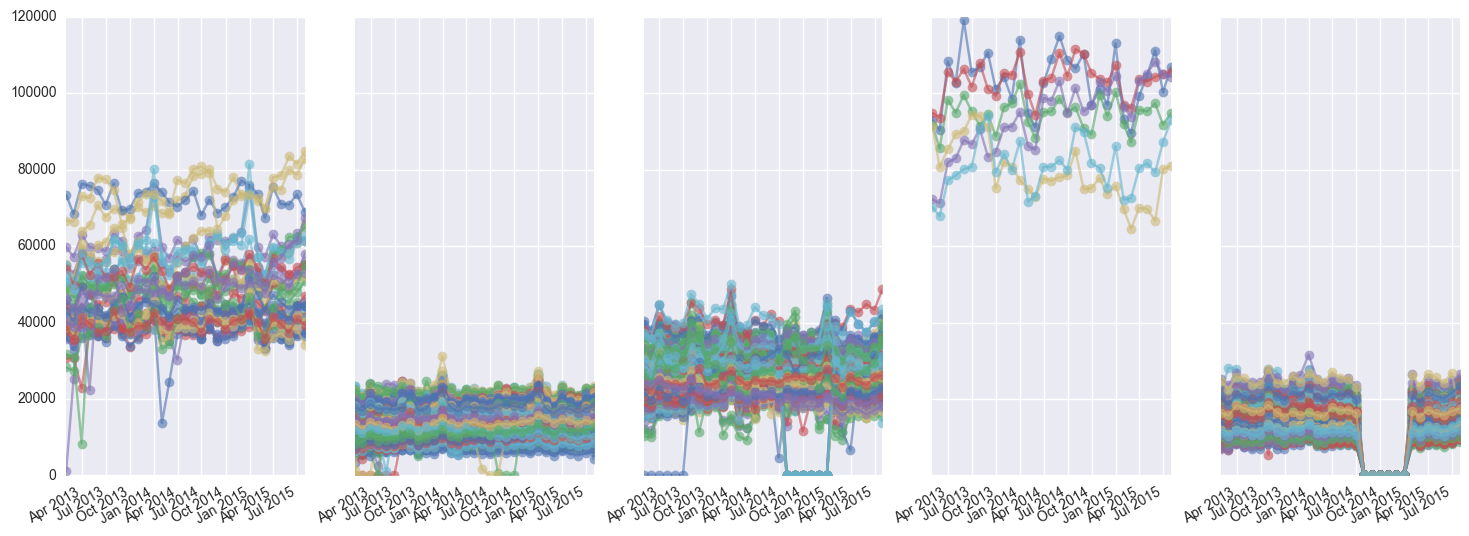

In [359]:
plot_clusters(chart_df, cl) 

In [364]:
train_df = train_df.set_index('Store').join(cl_df)
test_df = test_df.set_index('Store').join(cl_df)

In [366]:
train_df = train_df.reset_index().set_index(['Store', 'Date']).sort_index()
test_df = test_df.reset_index().set_index(['Store', 'Date']).sort_index()

0.837065707265


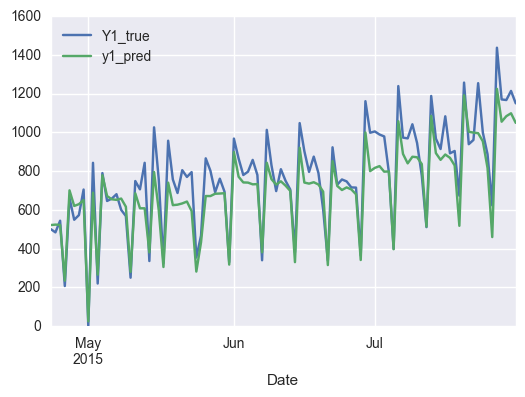

In [372]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200)

X = train_df.loc[732]

y1 = X.pop('Customers')
y2 = X.pop('Sales') 

clf.fit(X[:-100], y1[:-100])
y1_pred = clf.predict(X[-100:])
model_result = pd.DataFrame({'Y1_true':y1[-100:].values, 'y1_pred': y1_pred}, index=y1[-100:].index)
model_fimp = pd.DataFrame({'imp': clf.feature_importances_, 'feature': X.columns}).sort_values(by='imp')

print (clf.score(X[-100:], y1[-100:]))
model_result.plot()

In [376]:
model_fimp.sort_values(by='imp', ascending=False)

feature       imp
0                  Open  0.285970
5          date_weeknum  0.245097
38          DayOfWeek_7  0.159620
2         SchoolHoliday  0.087846
4            date_month  0.067808
39      days_since_comp  0.045110
3              date_day  0.029323
32          DayOfWeek_1  0.022094
28       StateHoliday_0  0.013894
29       StateHoliday_1  0.011350
37          DayOfWeek_6  0.010858
1                 Promo  0.007527
36          DayOfWeek_5  0.002610
6             date_year  0.002451
34          DayOfWeek_3  0.002150
33          DayOfWeek_2  0.001784
35          DayOfWeek_4  0.001782
30       StateHoliday_2  0.001550
31       StateHoliday_3  0.001176
7   CompetitionDistance  0.000000
14              ProInt6  0.000000
21         Assortment_a  0.000000
40     days_since_promo  0.000000
19             ProInt11  0.000000
27          StoreType_d  0.000000
26          StoreType_c  0.000000
25          StoreType_b  0.000000
24          StoreType_a  0.000000
23         Assortment_c  0.000000
22         Assortment_b  0.000000
41             is_promo  0.000000
20             ProInt12  0.000000
18             ProInt10  0.000000
9               ProInt1  0.000000
17              ProInt9  0.000000
16              ProInt8  0.000000
15              ProInt7  0.000000
42              cluster  0.000000
13              ProInt5  0.000000
12              ProInt4  0.000000
11              ProInt3  0.000000
10              ProInt2  0.000000
8                Promo2  0.000000

In [380]:
test_df.head()

Id  DayOfWeek  Open  Promo StateHoliday  SchoolHoliday  \
Store Date                                                                    
1     2015-08-01  40233          6   1.0      0            0              1   
      2015-08-02  39377          7   0.0      0            0              1   
      2015-08-03  38521          1   1.0      1            0              1   
      2015-08-04  37665          2   1.0      1            0              1   
      2015-08-05  36809          3   1.0      1            0              1   

                  date_day  date_month  date_weeknum  date_year StoreType  \
Store Date                                                                  
1     2015-08-01         1           8            31       2015         c   
      2015-08-02         2           8            31       2015         c   
      2015-08-03         3           8            32       2015         c   
      2015-08-04         4           8            32       2015         c   
      2015-08-05         5           8            32       2015         c   

                 Assortment  CompetitionDistance  Promo2  ProInt1  ProInt2  \
Store Date                                                                   
1     2015-08-01          a               1270.0       0        0        0   
      2015-08-02          a               1270.0       0        0        0   
      2015-08-03          a               1270.0       0        0        0   
      2015-08-04          a               1270.0       0        0        0   
      2015-08-05          a               1270.0       0        0        0   

                  ProInt3  ProInt4  ProInt5  ProInt6  ProInt7  ProInt8  \
Store Date                                                               
1     2015-08-01        0        0        0        0        0        0   
      2015-08-02        0        0        0        0        0        0   
      2015-08-03        0        0        0        0        0        0   
      2015-08-04        0        0        0        0        0        0   
      2015-08-05        0        0        0        0        0        0   

                  ProInt9  ProInt10  ProInt11  ProInt12  days_since_comp  \
Store Date                                                                 
1     2015-08-01        0         0         0         0             2525   
      2015-08-02        0         0         0         0             2526   
      2015-08-03        0         0         0         0             2527   
      2015-08-04        0         0         0         0             2528   
      2015-08-05        0         0         0         0             2529   

                  days_since_promo  cluster  
Store Date                                   
1     2015-08-01                 0        1  
      2015-08-02                 0        1  
      2015-08-03                 0        1  
      2015-08-04                 0        1  
      2015-08-05                 0        1

In [382]:
customer_score = []
customer_pred = []
customer_fimp = []
sales_score = []
sales_pred = []
sales_fimp = []

for i in store.index.values:
    print("Fitting store: ", i)
    X = train_df.loc[i+1]
    X_test = test_df.loc[i+1]
    X_test.pop('Id')
    
    y1 = X.pop('Customers')
    y2 = X.pop('Sales')
    
    clf.fit(X, y1)
    y1_pred = clf.predict(X_test)   
    customer_pred.append(y1_pred) 
    
    clf.fit(X, y2)
    y2_pred = clf.predict(X_test) 
    sales_pred.append(y2_pred)

Fitting store:  0


ValueError: could not convert string to float: 'a'